# Analyze residential property assessment appeals for 2022S and 2023, by census tract

In [59]:
from sqlalchemy import create_engine
import json
import pandas as pd
import requests

In [60]:
db = create_engine('postgresql://jon@localhost:5432/propertydb')

In [27]:
appeals = pd.read_sql_query("""SELECT DISTINCT(appeals.parcelid), assessments.municode::int
FROM appeals
JOIN assessments
ON appeals.parcelid = assessments.parcelid
WHERE filer = 'PROPERTY OWNER'
AND appealperiod IN ('2022S', '2023');""", db)
appeals = appeals.municode.value_counts().to_frame().reset_index()

### collapse clairton/pgh/mck/duq

In [4]:
### Import median income census data
# https://api.census.gov/data/2021/acs/acs5/profile?get=NAME,DP03_0063E&for=county%20subdivision:*&in=state:42%20county:003

In [40]:
with open('input/census.json', 'r') as f:
    jsondata = json.load(f)
census = pd.DataFrame(data=jsondata[1:], columns=jsondata[0])
census = census.rename(columns={ 'DP03_0063E': 'medincome', 'county subdivision': 'fips' })
census['medincome'] = census.medincome.astype('int64')
census['fips'] = census.fips.astype('int64')

In [32]:
### Import census-appeals matcher
# https://data.wprdc.org/datastore/dump/44ef6677-ade7-4fda-a32c-93cf124cf09b?fields=fips,municode&format=csv
censusmatcher = pd.read_csv('input/fipsmunicode.csv')

In [47]:
pd.merge(
    pd.merge(appeals, censusmatcher, on='municode')[['count', 'fips']],
    census[['fips', 'NAME', 'medincome']],
    on='fips'
).to_csv('medincome-ownerappeals.csv', index=False)

### Create method for getting an appealed property's tract

In [95]:
def get_appeal_tract(appealedproperty):
    r = requests.get(
        'https://geocoding.geo.census.gov/geocoder/geographies/coordinates',
        params={
            'x': appealedproperty.lon,
            'y': appealedproperty.lat,
            'benchmark': 4,
            'format': 'json',
            'layers': 'census tracts',
            'vintage': 4
        }).json()

    return r['result']['geographies']['Census Tracts'][0]['TRACT']

### Get residential appeals, merge with their coordinates

In [129]:
alreadyprocessed = pd.concat([
    pd.read_csv('first1000.csv'), #0-1000
    pd.read_csv('1000batch2.csv'), #1-2
    pd.read_csv('1000batch3.csv'), #2-3
    pd.read_csv('1000batch4.csv'), #3-4,
    pd.read_csv('1000batch5.csv'), #4-5,
    pd.read_csv('1000batch6.csv')
])

In [130]:
# appeals = pd.read_sql_query("""SELECT DISTINCT(appeals.parcelid), address, muni, lat, lon
# FROM appeals
# JOIN parcelcentroids
# ON appeals.parcelid = parcelcentroids.parcelid
# WHERE filer = 'PROPERTY OWNER'
# AND type = 'R-RESIDENTIAL'
# AND appealperiod IN ('2022S', '2023')
# ORDER BY appeals.parcelid DESC;""", db)

# appeals = appeals[~appeals.parcelid.isin(alreadyprocessed.parcelid)].head(1000)

### Get census tract for appeals

In [131]:
# appeals['tract'] = appeals.apply(get_appeal_tract, axis=1)
# appeals

In [ ]:
# https://geocoding.geo.census.gov/geocoder/locations/address?street=4600+Silver+Hill+Rd&city=Washington&state=DC&benchmark=2020&format=json
# https://geocoding.geo.census.gov/geocoder/locations/coordinates?x=-80.056093834500544&y=40.608301167102347&benchmark=2020&format=json
# https://api.census.gov/data/2021/acs/acs5/profile?get=NAME,DP03_0063E&for=tract:*&in=state:42%20county:003

,tract,count
0,437000,180
1,409002,93
2,409001,86
3,456003,82
4,422000,80
...,...,...
356,270300,1
357,485000,1
358,100500,1
359,80900,1


In [183]:
# with open('input/tractincome.json', 'r') as f:
#     jsondata = json.load(f)

# medincome: DP03_0063E
# % bach or higher: DP02_0068PE

census = requests.get(
    'https://api.census.gov/data/2021/acs/acs5/profile?get=NAME,DP04_0089E&for=tract:*&in=state:42%20county:003'
)
census = census.json()
census = pd.DataFrame(data=census[1:], columns=census[0])
census = census.rename(columns={ 'DP04_0089E': 'censusvariable' })
census['censusvariable'] = census.censusvariable.astype('float64')
census['tract'] = census.tract.astype('int64')

In [184]:
merged = pd.merge(
    alreadyprocessed.tract.value_counts().to_frame().reset_index(),
    census,
    on='tract',
    how='outer'
)
merged['count'] = merged['count'].fillna(0)
# merged.to_csv('merged.csv', index=False)

In [155]:
# merged.sort_values(by='medincome')

<Axes: xlabel='censusvariable', ylabel='count'>

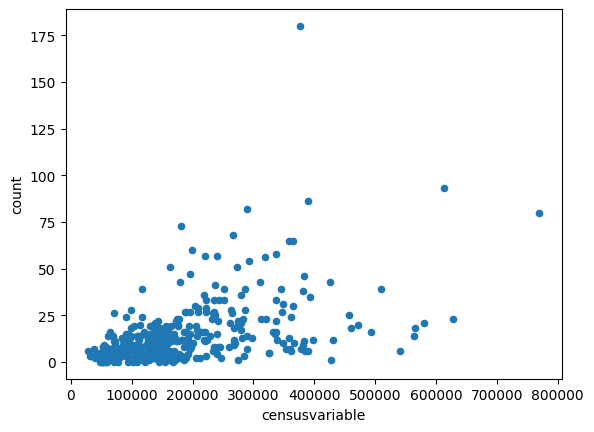

In [185]:
merged[merged.censusvariable > 0].plot.scatter(x='censusvariable', y='count')